Bootstrapping

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_13548\1492400551.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv("../data/cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
gate_30 = data[data.version == 'gate_30']
gate_40 = data[data.version == 'gate_40']

По существующей выборке берём подвыборки, вычияляем для каждой искомое значение и берём среднее по выборкам

In [30]:
def bootstrap_median(dataframe, column, iters, name):
    boot_data = []
    for i in range(iters):
        boot_mean = dataframe.sample(frac = 1, replace = True)[column].mean()
        boot_data.append(boot_mean)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 2000
boot_30 = bootstrap_median(gate_30, 'retention_7', iterations, 'gate_30')
boot_40 = bootstrap_median(gate_40, 'retention_7', iterations, 'gate_40')
boot = boot_30.merge(boot_40, left_index=True, right_index=True)
boot['diff'] = boot['gate_30'] - boot['gate_40']

In [35]:
print('Gate 30. Original mean:', gate_30['retention_7'].mean())
print('Gate 30. Bootstrap mean:', boot['gate_30'].mean())
print('Gate 40. Original mean:', gate_40['retention_7'].mean())
print('Gate 30. Bootstrap mean:', boot['gate_40'].mean())

Gate 30. Original mean: 0.19020134228187918
Gate 30. Bootstrap mean: 0.19021829977628635
Gate 40. Original mean: 0.18200004396667327
Gate 30. Bootstrap mean: 0.18196743168678142


<Axes: ylabel='Density'>

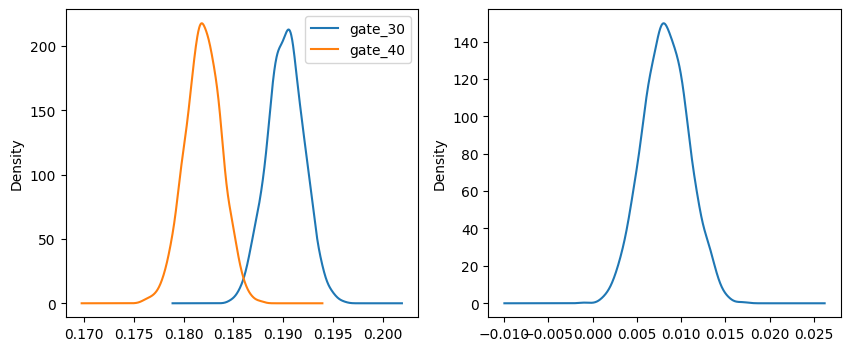

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
boot[['gate_30', 'gate_40']].plot(kind='density', ax=ax1)
boot['diff'].plot(kind='density', ax=ax2)

In [63]:
sizes = [10, 100, 1000, 10000, 40000]
boot = []

for size in sizes:
    subframe = gate_30[:size]
    retention_mean = []
    gamerounds_median = []
    for i in range(iterations):
        sample = subframe.sample(frac = 1, replace = True)
        retention_mean.append(sample['retention_7'].mean())
        gamerounds_median.append(sample['sum_gamerounds'].median())
    boot.append([np.mean(retention_mean),
                 subframe['retention_7'].mean(),
                 np.mean(gamerounds_median),
                 subframe['sum_gamerounds'].median()])

pd.DataFrame(np.array(boot).T, columns=sizes, index=['retention_7_boot_mean', 'retention_7_mean', 'sum_gameround_boot_median', 'sum_gameround_median'])

,10,100,1000,10000,40000
retention_7_boot_mean,0.30075,0.180535,0.199855,0.192,0.190096
retention_7_mean,0.30000,0.180000,0.200000,0.192,0.190150
sum_gameround_boot_median,46.07300,15.268500,14.913000,16.773,16.985500
sum_gameround_median,38.50000,14.000000,15.000000,17.000,17.000000


Коррекция смещения (bias correction)

In [64]:
def bootstrap_median(dataframe, column, iters, name):
    boot_data = []
    for i in range(iters):
        boot_mean = dataframe.sample(frac = 1, replace = True)[column].median()
        boot_data.append(boot_mean)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 2000
boot_30_median = bootstrap_median(gate_30, 'sum_gamerounds', iterations, 'gate_30')
boot_40_median = bootstrap_median(gate_40, 'sum_gamerounds', iterations, 'gate_40')
boot = boot_30_median.merge(boot_40_median, left_index=True, right_index=True)
boot['diff'] = boot['gate_30'] - boot['gate_40']

In [90]:
orig_theta = np.median(gate_30['sum_gamerounds'])
boot_theta = np.mean(boot_30_median)
delta_val = boot_theta - orig_theta

In [91]:
#куда?
boot_corrected = [i - delta_val for i in boot_30_median['gate_30']] 

In [92]:
boot_30_median['gate_30'].mean(), np.mean(boot_corrected), gate_30['sum_gamerounds'].median()

(16.95825, 17.000000000000004, 17.0)

<Axes: ylabel='Density'>

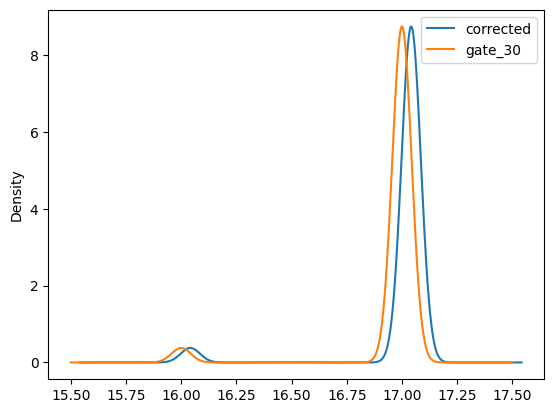

In [93]:
pd.DataFrame(boot_corrected, columns=['corrected']).merge(boot_30_median, left_index=True, right_index=True).plot(kind='density')

Проверка гипотезы

In [109]:
boot_data = []

for _ in range(iterations):
    boot_30 = gate_30.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_40 = gate_40.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_data.append(boot_30 - boot_40)
    # надо вариант с вычислением t на каждой итерации?

orig_theta = gate_30['retention_7'].mean() - gate_40['retention_7'].mean()
boot_theta = np.mean(boot_data)
delta_val = orig_theta - boot_theta
boot_corrected = [i + delta_val for i in boot_data]

In [110]:
np.mean(boot_corrected), orig_theta

(0.008201298315205911, 0.008201298315205913)

In [111]:
alpha = 0.05

left_ci = alpha / 2
right_ci = 1 - alpha / 2
pd.DataFrame(boot_corrected).quantile([left_ci, right_ci])

,0
0.025,0.002979
0.975,0.013306


In [112]:
mean = np.mean(boot_corrected)
std = np.std(boot_corrected)
p_1 = norm.cdf(x=0, loc=mean, scale=std)
p_2 = norm.cdf(x=0, loc=-mean, scale=std)
p_value = min(p_1, p_2) * 2
p_value

0.0016103490372420053

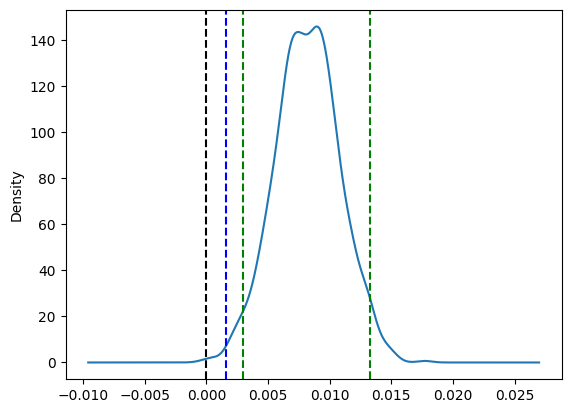

In [115]:
sr = pd.Series(boot_corrected)
sr.plot(kind='density')
plt.axvline(x=0, color='black', linestyle='--')
plt.axvline(x=p_value, color='blue', linestyle='--')
plt.axvline(x=sr.quantile(left_ci), color='green', linestyle='--')
plt.axvline(x=sr.quantile(right_ci), color='green', linestyle='--')